# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import os
from glob import glob
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [15]:
# mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

# i=0


# for batch_images in mnist_dataset.get_batches(50):  
#     i+=1
#     print('next')
#     pass
 
# print(i)

## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

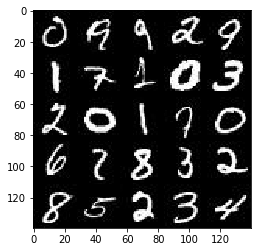

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

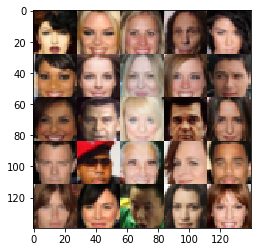

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [142]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [143]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
   
    learn_rate=tf.placeholder(tf.float32)
    input_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels))
    input_z=tf.placeholder(tf.float32,(None,z_dim))
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

tests.test_model_inputs(model_inputs)


Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [144]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
   
        alpha=0.5
        
        x1 = tf.layers.conv2d(images, 16, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)

        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        

        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 204800))

        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

     
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [157]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha=0.5

        x1=tf.layers.dense(z,7*7*256)

        x1=tf.reshape(x1,(-1,7,7,256))
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128,1, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
   
        x3 = tf.layers.conv2d_transpose(x1, 64,1, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
   

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 1, strides=2, padding='same')
        
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [158]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [159]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [160]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [161]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
  


    input_real, input_z,lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
 
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):      
                steps += 1


                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))             
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,input_z: batch_z,lr:learning_rate})
               
                if steps % 100 == 0:
                    show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)   
             # At the end of each epoch, get the losses and print them out
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    
       

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 6.4314... Generator Loss: 0.0219
Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 8.5210
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 5.1627... Generator Loss: 0.0103
Epoch 1/2... Discriminator Loss: 2.2188... Generator Loss: 0.2050
Epoch 1/2... Discriminator Loss: 5.9849... Generator Loss: 0.0081
Epoch 1/2... Discriminator Loss: 6.1250... Generator Loss: 0.0039
Epoch 1/2... Discriminator Loss: 4.7015... Generator Loss: 0.0165
Epoch 1/2... Discriminator Loss: 5.0995... Generator Loss: 0.0211
Epoch 1/2... Discriminator Loss: 4.8109... Generator Loss: 0.0123
Epoch 1/2... Discriminator Loss: 4.7372... Generator Loss: 0.0212
Epoch 1/2... Discriminator Loss: 3.3159... Generator Loss: 0.0589
Epoch 1/2... Discriminator Loss: 3.9782... Generator Loss: 0.0309
Epoch 1/2... Discriminator Loss: 7.8197... Generator Loss: 0.0035
Epoch 1/2... Discriminator Loss: 5.2402... Generator Loss: 0.0074
Epoch 1/2.

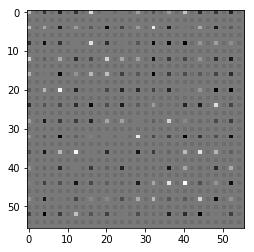

Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.9547
Epoch 1/2... Discriminator Loss: 1.5022... Generator Loss: 2.0162
Epoch 1/2... Discriminator Loss: 1.6680... Generator Loss: 1.4104
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 2.8907
Epoch 1/2... Discriminator Loss: 6.6018... Generator Loss: 0.2473
Epoch 1/2... Discriminator Loss: 2.5415... Generator Loss: 0.1627
Epoch 1/2... Discriminator Loss: 1.8496... Generator Loss: 0.3596
Epoch 1/2... Discriminator Loss: 2.2753... Generator Loss: 0.1828
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 5.2133... Generator Loss: 0.2084
Epoch 1/2... Discriminator Loss: 4.5295... Generator Loss: 0.4012
Epoch 1/2... Discriminator Loss: 2.9496... Generator Loss: 4.1633
Epoch 1/2... Discriminator Loss: 2.9057... Generator Loss: 5.9889
Epoch 1/2... Discriminator Loss: 6.3259... Generator Loss: 0.4963
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.6228
Epoch 1/2.

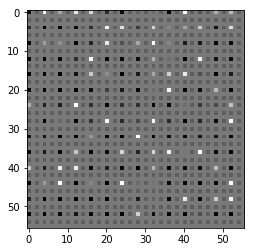

Epoch 1/2... Discriminator Loss: 4.6115... Generator Loss: 4.4928
Epoch 1/2... Discriminator Loss: 2.5998... Generator Loss: 1.7368
Epoch 1/2... Discriminator Loss: 1.8453... Generator Loss: 2.1281
Epoch 1/2... Discriminator Loss: 1.9759... Generator Loss: 2.0006
Epoch 1/2... Discriminator Loss: 2.4860... Generator Loss: 0.3311
Epoch 1/2... Discriminator Loss: 0.6846... Generator Loss: 1.6083
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 6.4222
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 3.6410
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 3.3937
Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 5.4081
Epoch 1/2... Discriminator Loss: 3.0061... Generator Loss: 2.2468
Epoch 1/2... Discriminator Loss: 0.7689... Generator Loss: 5.5256
Epoch 1/2... Discriminator Loss: 3.1879... Generator Loss: 5.6767
Epoch 1/2... Discriminator Loss: 0.3728... Generator Loss: 3.2073
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 1.6741
Epoch 1/2.

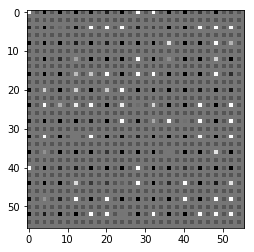

Epoch 1/2... Discriminator Loss: 5.8807... Generator Loss: 0.0140
Epoch 1/2... Discriminator Loss: 2.8704... Generator Loss: 0.1349
Epoch 1/2... Discriminator Loss: 3.8388... Generator Loss: 0.0666
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 2.6963
Epoch 1/2... Discriminator Loss: 4.1264... Generator Loss: 0.2350
Epoch 1/2... Discriminator Loss: 2.3278... Generator Loss: 0.2361
Epoch 1/2... Discriminator Loss: 0.6469... Generator Loss: 1.7006
Epoch 1/2... Discriminator Loss: 2.4366... Generator Loss: 0.1333
Epoch 1/2... Discriminator Loss: 0.3681... Generator Loss: 4.1123
Epoch 1/2... Discriminator Loss: 3.4808... Generator Loss: 5.3677
Epoch 1/2... Discriminator Loss: 2.9551... Generator Loss: 0.1148
Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 1.9202
Epoch 1/2... Discriminator Loss: 0.5956... Generator Loss: 1.7974
Epoch 1/2... Discriminator Loss: 0.4674... Generator Loss: 2.7768
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.4536
Epoch 1/2.

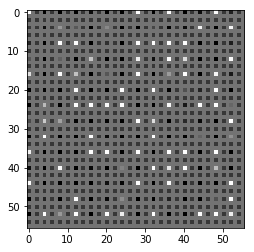

Epoch 1/2... Discriminator Loss: 5.4617... Generator Loss: 0.0113
Epoch 1/2... Discriminator Loss: 3.2641... Generator Loss: 0.1267
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 1.2709
Epoch 1/2... Discriminator Loss: 9.7324... Generator Loss: 0.0114
Epoch 1/2... Discriminator Loss: 4.3497... Generator Loss: 0.0216
Epoch 1/2... Discriminator Loss: 4.6608... Generator Loss: 0.0138
Epoch 1/2... Discriminator Loss: 0.8575... Generator Loss: 3.5515
Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 2.2784
Epoch 1/2... Discriminator Loss: 0.5727... Generator Loss: 2.9954
Epoch 1/2... Discriminator Loss: 5.5311... Generator Loss: 0.2418
Epoch 1/2... Discriminator Loss: 4.8842... Generator Loss: 0.0116
Epoch 1/2... Discriminator Loss: 5.8500... Generator Loss: 0.0040
Epoch 1/2... Discriminator Loss: 4.7757... Generator Loss: 0.0142
Epoch 1/2... Discriminator Loss: 3.5022... Generator Loss: 0.0469
Epoch 1/2.

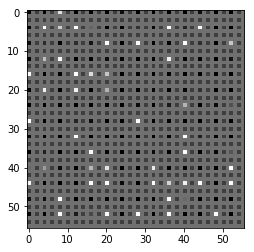

Epoch 1/2... Discriminator Loss: 5.4063... Generator Loss: 3.7023
Epoch 1/2... Discriminator Loss: 0.7422... Generator Loss: 9.3424
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 4.1229
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 8.0007
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 7.5163
Epoch 1/2... Discriminator Loss: 5.4370... Generator Loss: 2.9181
Epoch 1/2... Discriminator Loss: 1.8559... Generator Loss: 2.0289
Epoch 1/2... Discriminator Loss: 2.2910... Generator Loss: 4.8285
Epoch 1/2... Discriminator Loss: 2.0759... Generator Loss: 0.4800
Epoch 1/2... Discriminator Loss: 1.8549... Generator Loss: 1.4521
Epoch 1/2... Discriminator Loss: 6.5434... Generator Loss: 0.0132
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 6.5304
Epoch 1/2... Discriminator Loss: 1.8654... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 8.2405... Generator Loss: 0.0005
Epoch 1/2.

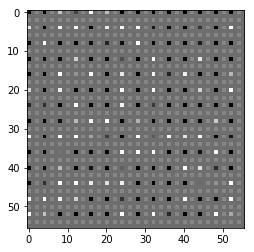

Epoch 1/2... Discriminator Loss: 1.7353... Generator Loss: 0.4751
Epoch 2/2... Discriminator Loss: 4.8805... Generator Loss: 0.1202
Epoch 2/2... Discriminator Loss: 7.2506... Generator Loss: 0.0040
Epoch 2/2... Discriminator Loss: 7.1404... Generator Loss: 0.0065
Epoch 2/2... Discriminator Loss: 2.4609... Generator Loss: 2.7515
Epoch 2/2... Discriminator Loss: 10.8627... Generator Loss: 0.0008
Epoch 2/2... Discriminator Loss: 2.2454... Generator Loss: 0.2362
Epoch 2/2... Discriminator Loss: 6.7551... Generator Loss: 0.0024
Epoch 2/2... Discriminator Loss: 3.3421... Generator Loss: 0.1637
Epoch 2/2... Discriminator Loss: 12.0134... Generator Loss: 0.0012
Epoch 2/2... Discriminator Loss: 10.9154... Generator Loss: 0.0000
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 18.0981
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 4.3977
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 7.2406
Epoch 2/2... Discriminator Loss: 0.8054... Generator Loss: 14.4344
Epoch

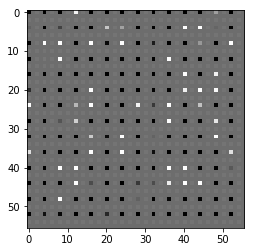

Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 4.7015
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 8.4182
Epoch 2/2... Discriminator Loss: 1.8090... Generator Loss: 13.2738
Epoch 2/2... Discriminator Loss: 0.3256... Generator Loss: 12.2474
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 12.2243
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 12.6177
Epoch 2/2... Discriminator Loss: 4.7151... Generator Loss: 15.3932
Epoch 2/2... Discriminator Loss: 0.5364... Generator Loss: 3.2387
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 14.3017
Epoch 2/2... Discriminator Loss: 2.2444... Generator Loss: 2.2913
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 10.0024
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 1.6436
Epoch 2/2... Discriminator Loss: 4.8812... Generator Loss: 8.0475
Epoch 2/2... Discriminator Loss: 5.6192... Generator Loss: 0.4174
Epoch 2/2... Discriminator Loss: 2.7678... Generator Loss: 2.9732
Epo

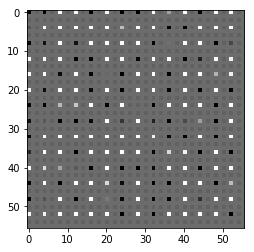

Epoch 2/2... Discriminator Loss: 2.8981... Generator Loss: 16.1983
Epoch 2/2... Discriminator Loss: 0.4932... Generator Loss: 14.3423
Epoch 2/2... Discriminator Loss: 4.4019... Generator Loss: 12.8273
Epoch 2/2... Discriminator Loss: 1.4709... Generator Loss: 8.1685
Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 4.2525
Epoch 2/2... Discriminator Loss: 0.6628... Generator Loss: 5.6890
Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 9.0520
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 10.4609
Epoch 2/2... Discriminator Loss: 0.8338... Generator Loss: 6.1293
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 1.9242
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 7.3534
Epoch 2/2... Discriminator Loss: 3.7709... Generator Loss: 13.9564
Epoch 2/2... Discriminator Loss: 2.3263... Generator Loss: 10.9040
Epoch 2/2... Discriminator Loss: 0.3260... Generator Loss: 8.7366
Epoch 2/2... Discriminator Loss: 1.6956... Generator Loss: 9.0222
Epoc

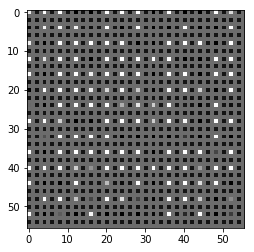

Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 10.5346
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 7.2709
Epoch 2/2... Discriminator Loss: 0.3997... Generator Loss: 7.4876
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 10.5576
Epoch 2/2... Discriminator Loss: 0.7482... Generator Loss: 8.1852
Epoch 2/2... Discriminator Loss: 1.5428... Generator Loss: 8.8081
Epoch 2/2... Discriminator Loss: 0.5784... Generator Loss: 9.7917
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 6.1704
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 7.7029
Epoch 2/2... Discriminator Loss: 1.6458... Generator Loss: 4.1926
Epoch 2/2... Discriminator Loss: 1.5064... Generator Loss: 10.9012
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 6.9342
Epoch 2/2... Discriminator Loss: 1.5037... Generator Loss: 15.1962
Epoch 2/2... Discriminator Loss: 4.5573... Generator Loss: 3.5560
Epoch 2/2... Discriminator Loss: 4.8744... Generator Loss: 5.9909
Epoch 

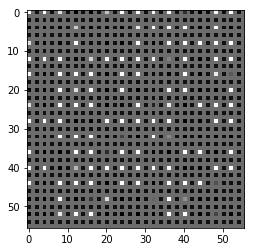

Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 6.3944
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 3.4281
Epoch 2/2... Discriminator Loss: 4.7069... Generator Loss: 1.6420
Epoch 2/2... Discriminator Loss: 5.4157... Generator Loss: 8.2660
Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.3593
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 6.5846
Epoch 2/2... Discriminator Loss: 1.9512... Generator Loss: 1.8965
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 1.4225
Epoch 2/2... Discriminator Loss: 2.7567... Generator Loss: 5.4031
Epoch 2/2... Discriminator Loss: 1.6043... Generator Loss: 3.7668
Epoch 2/2... Discriminator Loss: 4.1639... Generator Loss: 7.5452
Epoch 2/2... Discriminator Loss: 2.4748... Generator Loss: 1.1863
Epoch 2/2... Discriminator Loss: 1.8648... Generator Loss: 2.1040
Epoch 2/2... Discriminator Loss: 1.1913... Generator Loss: 5.3640
Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 10.3256
Epoch 2/2

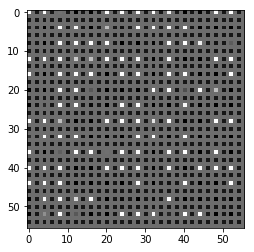

Epoch 2/2... Discriminator Loss: 3.8525... Generator Loss: 10.9685
Epoch 2/2... Discriminator Loss: 0.5949... Generator Loss: 5.2738
Epoch 2/2... Discriminator Loss: 4.8718... Generator Loss: 0.9444
Epoch 2/2... Discriminator Loss: 2.7877... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 6.6898
Epoch 2/2... Discriminator Loss: 4.5285... Generator Loss: 2.4901
Epoch 2/2... Discriminator Loss: 1.5970... Generator Loss: 4.5862
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.9185
Epoch 2/2... Discriminator Loss: 1.4831... Generator Loss: 2.1234
Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 13.4427
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 6.3466
Epoch 2/2... Discriminator Loss: 1.6024... Generator Loss: 10.6815
Epoch 2/2... Discriminator Loss: 0.4464... Generator Loss: 7.1689
Epoch 2/2... Discriminator Loss: 0.4138... Generator Loss: 16.6319
Epoch 2/2... Discriminator Loss: 1.5628... Generator Loss: 12.6028
Epoch

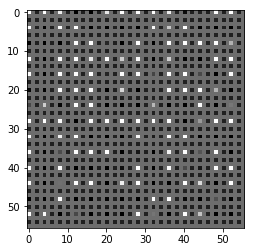

Epoch 2/2... Discriminator Loss: 0.3860... Generator Loss: 6.6821


In [163]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 2.1001
Epoch 1/1... Discriminator Loss: 4.4537... Generator Loss: 0.0276
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.5563
Epoch 1/1... Discriminator Loss: 1.7157... Generator Loss: 0.2874
Epoch 1/1... Discriminator Loss: 1.8568... Generator Loss: 0.2476
Epoch 1/1... Discriminator Loss: 1.8629... Generator Loss: 0.2466
Epoch 1/1... Discriminator Loss: 1.8641... Generator Loss: 0.2466
Epoch 1/1... Discriminator Loss: 2.8244... Generator Loss: 0.1379
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 2.1595... Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 1.9784... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.3434
Epoch 1/1... Discriminator Loss: 1.6328... Generator Loss: 0.3279
Epoch 1/1... Discriminator Loss: 2.0286... Generator Loss: 0.2166
Epoch 1/1... Discriminator Loss: 2.6679... Generator Loss: 0.1896
Epoch 1/1.

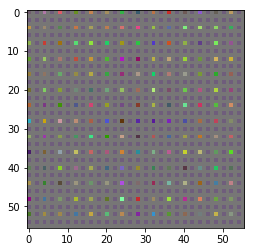

Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 2.3925
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 2.4363
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 2.0037
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 2.1917
Epoch 1/1... Discriminator Loss: 3.4684... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.8590... Generator Loss: 0.2878
Epoch 1/1... Discriminator Loss: 2.2313... Generator Loss: 0.2936
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.7989
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.7661
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 3.4322
Epoch 1/1.

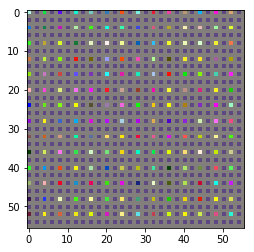

Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.7451
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.5045
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 3.1301
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 2.2556
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 2.3735
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 4.5614
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 3.5517
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 2.2261
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 4.0530
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 5.6852
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 3.5170
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 2.5047
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 2.8187
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 2.3178
Epoch 1/1.

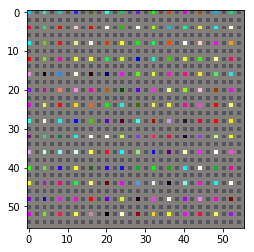

Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 4.4354
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 4.9922
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 3.6340
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 4.9424
Epoch 1/1... Discriminator Loss: 2.4212... Generator Loss: 3.7287
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 4.0463
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 2.0811
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 6.4677
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 4.0452
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 3.6376
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 3.3687
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 2.5695
Epoch 1/1.

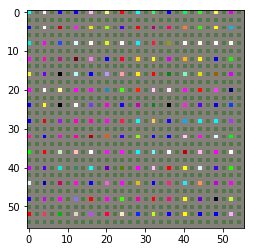

Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 2.8903
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 3.0746
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 1.7555
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 2.2767
Epoch 1/1... Discriminator Loss: 1.8208... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.8375... Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 2.4331
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.4445
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 3.5121
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 4.7314
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 4.0443
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 2.2401
Epoch 1/1.

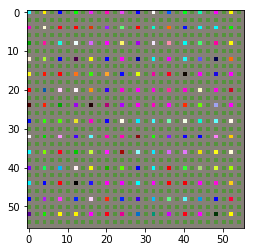

Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 2.5472
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 4.9004
Epoch 1/1... Discriminator Loss: 2.9900... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.9756... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 3.6424
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 2.3316
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 5.8200
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.9989
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.5303
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 6.4053
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 5.4378
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 4.1403
Epoch 1/1... Discriminator Loss: 3.3300... Generator Loss: 1.0464
Epoch 1/1.

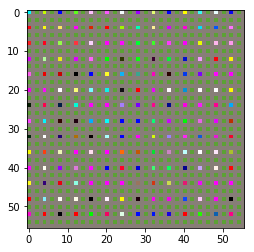

Epoch 1/1... Discriminator Loss: 0.3495... Generator Loss: 4.6007
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 5.2097
Epoch 1/1... Discriminator Loss: 2.9730... Generator Loss: 3.4407
Epoch 1/1... Discriminator Loss: 2.9946... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 1.8754... Generator Loss: 2.0660
Epoch 1/1... Discriminator Loss: 3.0410... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 2.1109... Generator Loss: 0.4457
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 1.9566
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 4.7813
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 5.2813
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 4.6181
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 3.8884
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 6.5545
Epoch 1/1.

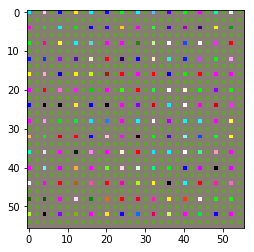

Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 5.8702
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 6.1726
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 5.3803
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 7.2556
Epoch 1/1... Discriminator Loss: 2.9896... Generator Loss: 2.6211
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 5.0556
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 3.1214
Epoch 1/1... Discriminator Loss: 1.6710... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 5.1766
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 4.1109
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 5.5118
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 3.7621
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 4.5778
Epoch 1/1... Discriminator Loss: 2.8034... Generator Loss: 2.3177
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 2.1447
Epoch 1/1.

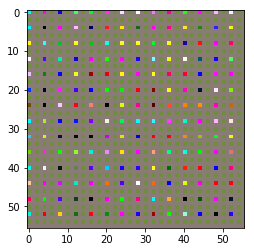

Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 3.4664
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 2.9589
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 2.3325
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 7.2746
Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 4.1704
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.1771
Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 2.3685
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 1.9465
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 6.2989
Epoch 1/1... Discriminator Loss: 2.4909... Generator Loss: 3.8245
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 2.8302
Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 1.7446
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 2.1797
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 3.9459
Epoch 1/1.

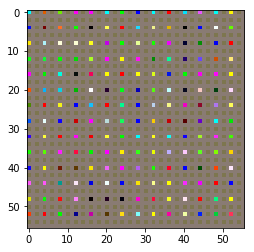

Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.8684
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 2.2233
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.8238
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 6.0833
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 6.1628
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 2.9941
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 4.8132
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 4.0784
Epoch 1/1... Discriminator Loss: 2.8752... Generator Loss: 4.2603
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 3.6258
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 2.2048
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.9075
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 3.0298
Epoch 1/1.

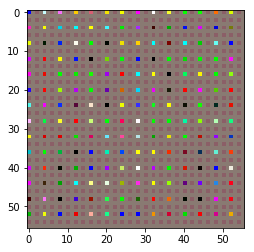

Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 3.6485
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 4.2961
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 4.3484
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 5.9662
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.7440
Epoch 1/1... Discriminator Loss: 3.1255... Generator Loss: 1.7892
Epoch 1/1... Discriminator Loss: 2.4914... Generator Loss: 0.2968
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 3.4955
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 4.8934
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 2.0688
Epoch 1/1.

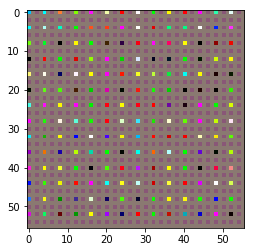

Epoch 1/1... Discriminator Loss: 1.9629... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 3.3039... Generator Loss: 0.3054
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 3.7018
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 6.0824
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 3.5340
Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 5.8227
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 4.5838
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 5.5332
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 8.1691
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 9.2358
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 3.3321
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 6.2716
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 3.7766
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 8.8434
Epoch 1/1.

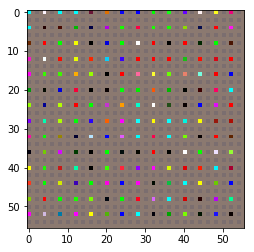

Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 4.9740
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 3.4830
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 5.0134
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 2.8045
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 1.6981
Epoch 1/1... Discriminator Loss: 2.9898... Generator Loss: 2.5035
Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 1.7873
Epoch 1/1... Discriminator Loss: 1.7186... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 2.8706
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 2.9965
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 3.7532
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.6410
Epoch 1/1... Discriminator Loss: 2.0801... Generator Loss: 2.2422
Epoch 1/1.

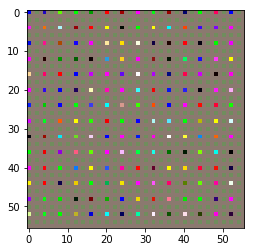

Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 4.2504
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 2.8967
Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 4.0448
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 6.1871
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 2.1804
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.0212
Epoch 1/1... Discriminator Loss: 3.1903... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.8371... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.4164
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 2.1406
Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 3.1662
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 2.3790
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 4.4788
Epoch 1/1.

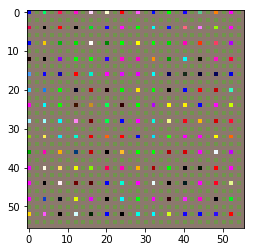

Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 4.3352
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 6.2516
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 5.7742
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 3.8570
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 3.6314
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 7.6885
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 5.9001
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 5.8943
Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 6.2930
Epoch 1/1... Discriminator Loss: 2.8829... Generator Loss: 3.6817
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 2.3234
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 2.4711
Epoch 1/1... Discriminator Loss: 2.5756... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 2.2515
Epoch 1/1.

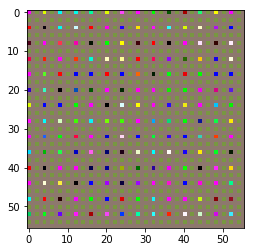

Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 6.4010
Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 3.0591
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 8.0484
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 6.9000
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 8.1146
Epoch 1/1... Discriminator Loss: 2.5604... Generator Loss: 6.0815
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 3.2623
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 3.7114
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 4.1829
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 5.0675
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 5.1532
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.2599
Epoch 1/1.

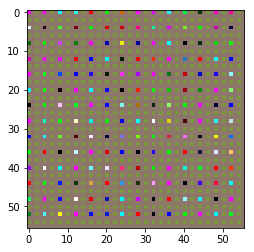

Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 1.7947
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 2.1773
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 4.9422
Epoch 1/1... Discriminator Loss: 2.3647... Generator Loss: 1.7987
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 4.8777
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 3.1510
Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 5.0902
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 2.3769
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 2.8120
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 4.5270
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.2085
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 3.0776
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 2.7630
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 3.6261
Epoch 1/1.

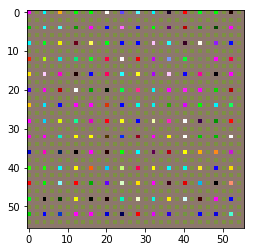

Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.5533
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 3.0993
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 3.8499
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 3.1456
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 4.4764
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 5.3094
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 3.5092
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.5236
Epoch 1/1... Discriminator Loss: 2.9020... Generator Loss: 2.2079
Epoch 1/1... Discriminator Loss: 1.7092... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 2.7502
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 3.5592
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 3.3567
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 1.9025
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 1.7919
Epoch 1/1.

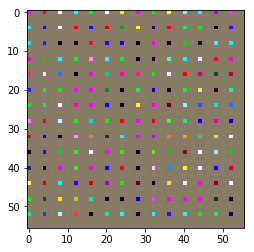

Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 5.9261
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 6.7014
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 7.4218
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 6.7166
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 8.6243
Epoch 1/1... Discriminator Loss: 2.3830... Generator Loss: 4.3367
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 3.4220
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 3.0431
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 4.2292
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 5.4597
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 4.6869
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 4.2029
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 2.7732
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 8.0313
Epoch 1/1... Discriminator Loss: 1.7564... Generator Loss: 5.9655
Epoch 1/1.

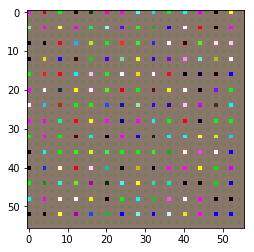

Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 4.9196
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 7.0696
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 7.3718
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 2.3679
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 6.1038
Epoch 1/1... Discriminator Loss: 0.3792... Generator Loss: 4.3814
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 4.1532
Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 4.9601
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 2.9293
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 4.3377
Epoch 1/1... Discriminator Loss: 2.4674... Generator Loss: 5.1231
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 3.0956
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 3.9443
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 3.9801
Epoch 1/1.

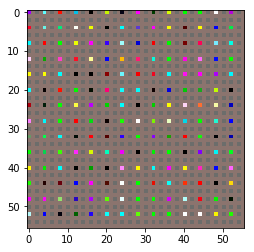

Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 8.9344
Epoch 1/1... Discriminator Loss: 2.4055... Generator Loss: 2.0520
Epoch 1/1... Discriminator Loss: 1.6401... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 3.9356
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 5.6876
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 2.6632
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 5.5125
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 3.9601
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 4.4406
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 6.8692
Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 7.4309
Epoch 1/1... Discriminator Loss: 3.0952... Generator Loss: 1.8949
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 4.5890
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 7.6007
Epoch 1/1.

In [164]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。